# Connect-Four Game

Connect-four is a board game with a $6\times 7$ grid. Each player has $21$ checkers distinguished by black (B) and red (R) colors. The board is a vertical board and player can only drop their checkers from the top in any of the $7$ columns if the column is not full.

Each player alternate dropping a checker from the top until:

* A player makes a row, a column, or a diagonal set of $4$ checkers.
* No moves left and no sets are made by any player. This case is a draw.

We first set up a game which can be used for human-versus-human play. Then, we explain the Monte Carlo Tree Search (MCTS) algorithm and use it for human-versus-machine and machine-versus-machine plays.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
players={1: "B", -1: "R", 0: "."}

def print_state(state):
    print("\n\t", end="")
    print("\n\t".join("  ".join([players[col] for col in row]) for row in state))
    print()

## Connect-Four Game Setup

We first set up a human-versus-human play. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [ ]:
class Connect4(object):
    def __init__(self):
        # Grid shape.
        self.nrows = 6
        self.ncols = 7
        # number of connections to be made for winning.
        self.k = 4
        self.first_player = 1

    def __repr__(self):
        return self.__class__.__name__

    def init_state(self):
        return np.zeros((self.nrows, self.ncols), dtype=np.int8)

    def next_state(self, state, action, player):
        """
        Returns the new state resulted by applying `action` taken by `player`
        on the current `state`.
        """
        col = action
        row = np.argwhere(state[:, col] == 0)[-1][0]
        state[row, col] = player
        return state

    def available_actions(self, state):
        return np.where(state[0, :] == 0)[0]

    def opponent(self, player):
        return -player

    def opponent_reward(self, reward):
        return -reward

    def neutral_perspective(self, state, player):
        return player * state

    def won(self, state, action):
        """
        Returns true if `action` taken resulted in a winnng `state`.
        """
        if action is None:
            return False

        col = action
        # Find the first nonzero element in this column
        row = np.argwhere(state[:, col] != 0)[0][0]
        player = state[row, col]

        for i in range(self.nrows - self.k + 1):
            total = np.sum(state[i : i + self.k, col])
            if total == self.k * player:
                return True

        for j in range(self.ncols - self.k + 1):
            total = np.sum(state[row, j : j + self.k])
            if total == self.k * player:
                return True

        diag = np.diag(state, col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j : j + self.k])
            if total == self.k * player:
                return True

        flipped_col = self.ncols - col - 1
        diag = np.diag(np.fliplr(state), flipped_col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j : j + self.k])
            if total == self.k * player:
                return True

        return False

    def is_over(self, state, action):
        if self.won(state, action):
            return 1
        if np.sum(state[0, :] == 0) == 0:
            return 0
        return -1


### Human-Human Play

In [ ]:
game = Connect4()
player = game.first_player
state = game.init_state()

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = game.available_actions(state)
    print(f"available actions: {game.available_actions(state)}")
    
    action = int(input("provide a valid move: "))
    state = game.next_state(state, action, player)
    
    is_over = game.is_over(state, action)
    if is_over >= 0:
        print_state(state)
        if is_over == 0:
            print("draw!")
        else:
            print(f"player {players[player]} won!")
        break
        
    player = game.opponent(player)


# Monte Carlo Tree Search

In this setion, we design a machine that can play against human or against another machine. We use Monte Carlo Tree Search (MCTS) to decide on the next move.

For a machine to be able to play against itself, we design it in a way that is agnostic of the player. We can assume that the player is always player 1, and change the perspective so that the machine acts as player -1. For calrification, consider the following state in a $6\times 7$ Connect-4 game:

$$
S = 
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & -1 & 1 & -1 & 0 & 0 & 0 \\
1 & 1 & 1 & -1 & -1 & 0 & 0
\end{pmatrix}
$$

Player -1 is to play. We can see this is equvalent to player 1 in state $-S$, where all elements are multiplied by $-1$. Thus, we can design MCTS algorithm which is player agnostic.

The MCTS algorithms is composed of four stages as follows:

1. Selection
2. Expansion
3. Simulation
4. Backpropagation

The input to the MCTS algorithm is the current state and the output is a probability distribution of all the possible moves. Based on the distribution, we can decide which action to take. This can be just the move with the highest probability.

<center>
<img src="./images/mcts-game.png" width="800">
</center>

From the output of the MCTS algorithm, we choose the next action as $6$ since it has the highest probability and it's a winning move for Player 1.

The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. Check if the current node is fully expanded or not. A node is fully expanded if it has children and no action can be taken.
2. If the node is fully expanded, we compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB.
3. Continue the process until you reach a node which is not fully expanded.
4. Expand the node and move to the expanded node.
5. Run a simulation from the current node to determine if the player is won. Return the reward.
6. Run backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+c\sqrt{\frac{\ln n_p}{n_c}},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $c$ is the exploration factor.

<center>
<img src="./images/mcts-nodes.png" width="200">
</center>


In [ ]:
params = {
    "exploration_factor": 2 ** 0.5,
    "num_iters": 100,
}

In [ ]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        self.available_actions = (state[0, :] == 0).astype(np.int8)
        
        self.reward_sum = 0
        self.visit_count = 0
        
    def expected_reward(self, child):
        return -child.reward_sum / child.visit_count
        
    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploration_factor = self.params["exploration_factor"]
        exploration = (np.log(self.visit_count) / child.visit_count) ** 0.5
        return self.expected_reward(child) + exploration_factor * exploration   
    
    def is_fully_expanded(self):
        return len(self.children) > 0 and (np.sum(self.available_actions) == 0)
    
    def select(self):
        return max(self.children, key=self.ucb)
    
    def expand(self):
        action = np.random.choice(np.where(self.available_actions == 1)[0])
        self.available_actions[action] = 0
        
        player = self.game.first_player
        other_player = self.game.opponent(player)
        
        child_state = self.game.next_state(self.state.copy(), action, player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        
        child = Node(self.game, child_state, self.params, self, action)
        self.children.append(child)
        
        return child
    
    def simulate(self):
        state = self.state.copy()
        parent_action = self.parent_action
        player = self.game.first_player
        
        # while game is not over...
        while self.game.is_over(state, parent_action) < 0:
            parent_action = np.random.choice(np.where(state[0, :] == 0)[0])
            state = self.game.next_state(state, parent_action, player)
            player = self.game.opponent(player)
        
        reward = self.game.is_over(state, parent_action)
        # `player` took `parent_action` which resulted in winning `state` so the winner is the
        # other player and we need to rever reward.
        reward = self.game.opponent_reward(reward)
        return reward if player == self.game.first_player else self.game.opponent_reward(reward)
    
    def backward(self, reward):
        """
        Backpropagate reward and visit counts from the node to the root.
        """
        node = self
        while node is not None:
            node.reward_sum += reward
            node.visit_count += 1
            reward = self.game.opponent_reward(reward)
            node = node.parent
    
class MCTS(object):
    def __init__(self, game, params):
        self.game = game
        self.params = params

    def best_policy(self, state):
        root = Node(self.game, state, self.params)
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            node = self.find_node(root)
            reward = node.simulate()
            node.backward(reward)

        return self.compute_policy(root)
  
    def find_node(self, root):
        node = root

        while self.game.is_over(node.state, node.parent_action) < 0:
            if not node.is_fully_expanded():
                return node.expand()
            node = node.select()   

        return node
    
    def compute_policy(self, node):
        out = np.zeros(self.game.ncols)
        for child in node.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out

## Human-Machine Play

In [ ]:
game = Connect4()
player = game.first_player
state = game.init_state()
mcts = MCTS(game, params)

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = game.available_actions(state)
    print(f"available actions: {game.available_actions(state)}")
    
    if player == game.first_player:
        action = int(input("provide a valid move: "))
    else:
        neutral_state = game.neutral_perspective(state, player)
        policy = mcts.best_policy(neutral_state)
        action = np.argmax(policy)        

        plt.bar(range(len(policy)), policy)
        plt.show()
    
    state = game.next_state(state, action, player)

    is_over = game.is_over(state, action)
    if is_over >= 0:
        print_state(state)
        if is_over == 0:
            print("draw!")
        else:
            print(f"player {players[player]} won!")
        break
        
    player = game.opponent(player)
        

## Machine-Machine PLay

In [ ]:
game = Connect4()
player = game.first_player
state = game.init_state()
mcts = MCTS(game, params)

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = game.available_actions(state)
    print(f"available actions: {game.available_actions(state)}")
    
    neutral_state = game.neutral_perspective(state, player)
    policy = mcts.best_policy(neutral_state)
    action = np.argmax(policy)        

    # plt.bar(range(len(policy)), policy)
    # plt.show()
    
    state = game.next_state(state, action, player)

    is_over = game.is_over(state, action)
    if is_over >= 0:
        print_state(state)
        if is_over == 0:
            print("draw!")
        else:
            print(f"player {players[player]} won!")
        break
        
    player = game.opponent(player)
        

# MCTS with Neural Networks

In this approach, we build a convolutional neural network (CNN) to predict policy and reward given a state. To train such a model, we use MCTS with slight modifications. We remove the simulation step and use an untrained CNN. Like the simulation, the untrained model plays randomly to generate training data.

We modify the tree search by replacing the simulation step with a neural network which returns a policy and a reward for a given state. The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. As long as the node has children, compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB. Repeat this until you reach a leaf node.
2. Given the current node state, run a convolutional neural network (CNN) to get the policy and reward.
3. Fully expand this leaf node using the policy.
4. Using the reward, run the backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

Using this MCTS approach, we generate enough training and validation dataset for model training. Then, we train our CNN model. Once the model is trained it can be used for playing actual games.

<center>
<img src="./images/mcts-cnn-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+cp_c\frac{\sqrt{n_p}}{1 + n_c},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $p_c$ is the prior probability provided by the policy from the CNN model for the child node state, 
* $c$ is the exploration factor.

## CNN Model

We build a CNN model that learns the following function which maps a state $S$ to a policy-reward pair $(P, R)$:

$$
f(S) = (P, R).
$$

The policy $P$ is a probability distribution of all possible next states from $S$ and $v$ is reward in $(-1, 1)$ which is interpreted as reward. Rewards close to $1$ indicates winning, while rewards close to $-1$ indicates losing. The rewards close to $0$ is interpreted as a drawish situation.

We interpret a state as an image in the CNN model. We use one-hot encoding for possible values $\{-1, 0, 1\}$ of each cell in a given state. So, let's define:

* $-1$: $[1, 0 ,0]$
* $\phantom{-}0$: $[0, 1 ,0]$
* $\phantom{-}1$: $[0, 0 ,1]$

As a result, we have a 3D input of size $3\times 6\times 7$ for a given state.

Then, we build multiple convolutional layers followed by two head as follows:

* **Policy Head:** The output layer size in this head is the number of possible next states. We apply softmax on the output layer to obtain a probability distribution which can be used to decide the next move.
* **Reward Head:** the output layer size in this head is one. We apply `Tanh` activation function to get a reward in $(-1, 1)$ representing a reward for the input state $S$. The reward is the model evaluation of a given state.

<center>
<img src="./images/connect4-cnn-model.png" width=800>
</center>

As we can see, we encode the current state and feed into the ResNet model which consists of multiple blocks arranged sequentially. A single block of the ResNet model consists of convolutional and batch normalization layers and ReLU activations as follows. Note that a skip connection is also added to the block.

<center>
<img src="./images/resnet-block.png" width=200>
</center>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange

In [297]:
params = {
    # CNN Model parameters
    "kernel_size": 3,
    "padding": 1,
    "embd_size": 3,
    "hidden_size": 128,
    "num_blocks": 8,
    "dropout": 0.1,
    # MCTS parameters
    "num_simulations": 100,
    "exploration_factor": 2,
    "dirichlet_epsilon": 0.25,
    "dirichlet_alpha": 0.3,
    # AlphaZero parameters
    "num_training_cycles": 2,
    "num_self_plays": 10,
    "num_epochs": 100,
    "batch_size": 16,
    "train_ratio": 0.9,
    # Training settings
    "load_model": False,
    # Plotting paramaters
    "loss_eval_size": 10,
    # Optimizer parameters
    "lr": 0.2,
    "weight_decay": 0.1,
    # General parameters
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


In the following, we build a convolutional neural network (CNN) which we descibed earlier.

In [298]:
class ResBlock(nn.Module):
    def __init__(self, hidden_size, params):
        super().__init__()

        kernel_size = params["kernel_size"]
        padding = params["padding"]
        dropout = params["dropout"]

        self.res_block = nn.Sequential(
            nn.Conv2d(
                hidden_size, hidden_size, kernel_size=kernel_size, padding=padding
            ),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(
                hidden_size, hidden_size, kernel_size=kernel_size, padding=padding
            ),
            nn.BatchNorm2d(hidden_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = x + self.res_block(x)
        out = F.relu(out)
        out = self.dropout(out)
        return out


class ResNet(nn.Module):
    def __init__(self, game, embd_size, hidden_size, num_blocks, params):
        super().__init__()

        kernel_size = params["kernel_size"]
        padding = params["padding"]
        dropout = params["dropout"]

        self.start_block = nn.Sequential(
            nn.Conv2d(embd_size, hidden_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.res_blocks = nn.ModuleList(
            [ResBlock(hidden_size, params) for _ in range(num_blocks)]
        )

        self.policy_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * game.nrows * game.ncols, game.ncols),
            nn.Dropout(dropout),
        )

        self.reward_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * game.nrows * game.ncols, 1),
            nn.Tanh(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        out = self.start_block(x)

        for res_block in self.res_blocks:
            out = res_block(out)

        logit = self.policy_head(out)
        reward = self.reward_head(out)

        return logit, reward


The following function encodes a $6\times 7$ state of a Connect4 game into a $3\times 6\times 7$ array, in which the first dimension if the embedding size.

In [299]:
def encode_state(state):
    """
    m, n = state.shape
    output size: 3 x m x n
    """
    return np.stack([state == 1, state == 0, state == -1]).astype(np.float32)


def decode_state(enc_state):
    return 1 * enc_state[0] + 0 * enc_state[1] + (-1) * enc_state[2]


We now design an MCTS class which implements the tree search. Starting from a root node, the algorithm select a child if the current node is fully expanded. If not, the algorithm fully expands it to all possible states.

We replace the simulation part of the MCTS with an untrained CNN model. Thus, the algorithm plays randomly for a set number of iterations and records states, policies, and rewards as training dataset.

Using the training dataset from random plays, we will train a CNN model. The trained model can then be used for actual playing without a need for MCTS.

In [306]:
class Node(object):
    def __init__(
        self, game, state, params, parent=None, parent_action=None, prior_prob=0, visit_count=0
    ):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action

        self.children = []

        self.reward_sum = 0
        self.visit_count = visit_count
        self.prior_prob = prior_prob

    def expected_reward(self, child):
        if child.visit_count == 0:
            return 0
        return -child.reward_sum / child.visit_count

    def ucb(self, child):
        """
        Computes the Upper Confidence Bound (UCB).
        """
        exploration_factor = self.params["exploration_factor"]
        exploration = (self.visit_count) ** 0.5 / (1 + child.visit_count)
        return (
            self.expected_reward(child)
            + exploration_factor * child.prior_prob * exploration
        )

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        return max(self.children, key=self.ucb)

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob == 0:
                continue

            player = self.game.first_player
            other_player = self.game.opponent(player)

            child_state = self.game.next_state(self.state.copy(), action, player)
            child_state = self.game.neutral_perspective(child_state, other_player)

            child = Node(self.game, child_state, self.params, self, action, prob)
            self.children.append(child)

    def backward(self, reward):
        """
        Backpropagate reward and visit counts from the node to the root.
        """
        self.reward_sum += reward
        self.visit_count += 1
        # parent node is the opponent of the child node.
        reward = self.game.opponent_reward(reward)
        if self.parent is not None:
            self.parent.backward(reward)


class MCTS(object):
    def __init__(self, params):
        self.game = Connect4()

        embd_size = params["embd_size"]
        hidden_size = params["hidden_size"]
        num_blocks = params["num_blocks"]
        device = params["device"]
        self.model = ResNet(self.game, embd_size, hidden_size, num_blocks, params).to(
            device
        )

        self.params = params

    def policy_reward(self, state):
        enc_state = encode_state(state)
        enc_state = torch.tensor(enc_state, device=self.params["device"]).unsqueeze(0)

        logit, reward = self.model(enc_state)
        reward = reward.item()
        # mask out illegal moves
        logit[:, state[0, :] != 0] = -np.inf
        policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()

        return policy, reward

    def dirichlet_policy(self, policy, state):
        eps, alpha = params["dirichlet_epsilon"], params["dirichlet_alpha"]
        dirichlet_noise = np.random.dirichlet([alpha] * len(policy))
        policy = (1 - eps) * policy + eps * dirichlet_noise
        # mask out illegal moves
        policy[state[0, :] != 0] = 0
        policy /= np.sum(policy)
        return policy

    @torch.no_grad()
    def best_policy(self, state):
        policy, _ = self.policy_reward(state)
        policy = self.dirichlet_policy(policy, state)

        root = Node(self.game, state, self.params, visit_count=1)
        root.expand(policy)

        num_simulations = self.params["num_simulations"]

        for _ in range(num_simulations):
            node = root

            while node.is_fully_expanded():
                node = node.select()

            is_over = self.game.is_over(node.state, node.parent_action)
            # check if it's not over.
            if is_over < 0:
                policy, reward = self.policy_reward(node.state)
                node.expand(policy)
            else:
                # 0 for draw and 1 for win
                reward = is_over
                reward = self.game.opponent_reward(reward)

            node.backward(reward)

        return self.compute_policy(root)

    def compute_policy(self, root):
        out = np.zeros(self.game.ncols)

        for child in root.children:
            out[child.parent_action] = child.visit_count

        out /= np.sum(out)
        return out


In the following, we define AlphaZero class, which implements:

* Training data generation through self-play.
* Model training using the training data.
* Repeating above two steps to refine the model.

We generate multiple training dataset from a single self-play. The algorithm plays randomly against itself until a player wins or it's a draw.

As an example, suppose Player $1$ starts the game and Player $-1$ wins after $6$ moves. We record $\{(S_i, P_i, R_i)\mid i=0,\ldots,6\}$, where $S_i$ and $P_i$ are the state and policy at move $i$ and $R_i$ is the reward assigned for each move once the game is over. In this particular case, since Player $-1$ won after $6$ moves, we have:

$$
R = [-1, 1, -1, 1, -1, 1].
$$

We can repeat this generation process by many self-plays to generate more training and validation datasets.

We now define two functions for training and evaluating data. For a number of epochs, we feed in the encoded states in batches to the model to obtain predicted policies and rewards for the batch. We then compute the losses for both policies and rewards. We optimize model parameters to minimize both losses.

At every training cycle, we evaluate the updated model against the evaluation dataset. We save the model at the end of each training cycle.

To organize training and evaluation losses for the policy and reward, we define the following classes.

In [ ]:
class Loss(object):
    def __init__(self):
        self.train = []
        self.eval = []


class Losses(object):
    def __init__(self):
        self.policy = Loss()
        self.reward = Loss()


In [304]:
class AlphaZero(object):
    def __init__(self, params):
        self.mcts = MCTS(params)

        lr = params["lr"]
        weight_decay = params["weight_decay"]
        self.optimizer = torch.optim.Adam(
            self.mcts.model.parameters(), lr=lr, weight_decay=weight_decay
        )

        self.params = params

    def generate_dataset(self, num_self_plays, data=None):
        if data is None:
            states, policies, rewards = [], [], []
        else:
            states, policies, rewards = data

        for _ in trange(num_self_plays):
            s, p, r = self.generate_data()
            states.extend(s)
            policies.extend(p)
            rewards.extend(r)

        return states, policies, rewards

    def generate_data(self):
        game = self.mcts.game
        player = game.first_player
        state = game.init_state()

        reward = 0
        states, policies, players = [], [], []

        while True:
            players.append(player)

            neutral_state = game.neutral_perspective(state, player)
            states.append(encode_state(neutral_state))

            policy = self.mcts.best_policy(neutral_state)
            policies.append(policy)

            action = np.random.choice(len(policy), p=policy)
            state = game.next_state(state, action, player)

            is_over = game.is_over(state, action)
            if is_over >= 0:
                reward = is_over
                break

            player = game.opponent(player)

        rewards = [
            reward if p == player else game.opponent_reward(reward) for p in players
        ]

        return states, policies, rewards

    def train_model(self, train_data, eval_data, losses=None):
        if losses is None:
            losses = Losses()

        states, policies, rewards = train_data
        num_epochs = self.params["num_epochs"]
        batch_size = self.params["batch_size"]
        device = self.params["device"]

        for _ in trange(num_epochs):
            self.mcts.model.train()
            batch_indices = np.random.choice(len(states), batch_size, replace=False)

            enc_states = torch.tensor(
                states[batch_indices], dtype=torch.float32, device=device
            )
            target_policies = torch.tensor(
                policies[batch_indices], dtype=torch.float32, device=device
            )
            target_rewards = torch.tensor(
                rewards[batch_indices], dtype=torch.float32, device=device
            ).unsqueeze(1)

            pred_logits, pred_rewards = self.mcts.model(enc_states)

            pred_policies = F.softmax(pred_logits, dim=1)
            policy_loss = F.cross_entropy(pred_policies, target_policies)
            reward_loss = F.mse_loss(pred_rewards, target_rewards)

            losses.policy.train.append(policy_loss.item())
            losses.reward.train.append(reward_loss.item())

            self.optimizer.zero_grad(set_to_none=True)
            policy_loss.backward(retain_graph=True)
            reward_loss.backward()
            self.optimizer.step()

            self.mcts.model.eval()
            policy_loss, reward_loss = self.eval_model(eval_data)
            losses.policy.eval.append(policy_loss.item())
            losses.reward.eval.append(reward_loss.item())

        return losses

    @torch.no_grad()
    def eval_model(self, eval_data):
        device = self.params["device"]

        states, policies, rewards = eval_data
        states, policies, rewards = (
            np.array(states),
            np.array(policies),
            np.array(rewards),
        )

        enc_states = torch.tensor(states, dtype=torch.float32, device=device)
        target_policies = torch.tensor(policies, dtype=torch.float32, device=device)
        target_rewards = torch.tensor(
            rewards, dtype=torch.float32, device=device
        ).unsqueeze(1)

        pred_logits, pred_rewards = self.mcts.model(enc_states)

        pred_policies = F.softmax(pred_logits, dim=1)
        policy_loss = F.cross_entropy(pred_policies, target_policies)
        reward_loss = F.mse_loss(pred_rewards, target_rewards)

        return policy_loss, reward_loss

    def split(self, data):
        states, policies, rewards = data
        states, policies, rewards = (
            np.array(states),
            np.array(policies),
            np.array(rewards),
        )
        num_records = len(states)
        train_ratio = params["train_ratio"]
        train_size = int(train_ratio * num_records)

        idx = np.random.choice(num_records, num_records, replace=False)
        train_idx, eval_idx = idx[:train_size], idx[train_size:]

        train_data = states[train_idx], policies[train_idx], rewards[train_idx]
        eval_data = states[eval_idx], policies[eval_idx], rewards[eval_idx]

        return train_data, eval_data

    def learn(self):
        num_training_cycles = params["num_training_cycles"]
        num_self_plays = params["num_self_plays"]
        losses = None

        for training_cycle in trange(num_training_cycles):
            data = self.generate_dataset(num_self_plays)
            train_data, eval_data = self.split(data)

            losses = self.train_model(train_data, eval_data, losses)

            model_checkpoint = {
                "model": self.mcts.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            model_location = f"./models/model_{self.mcts.game}_{training_cycle}.pt"

            torch.save(model_checkpoint, model_location)

        torch.save(model_checkpoint, f"./models/model_{self.mcts.game}_latest.pt")

        losses_location = f"./data/losses_{self.mcts.game}.pt"
        torch.save(losses, losses_location)

        return losses


## Trained Model Against Untrained Model

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

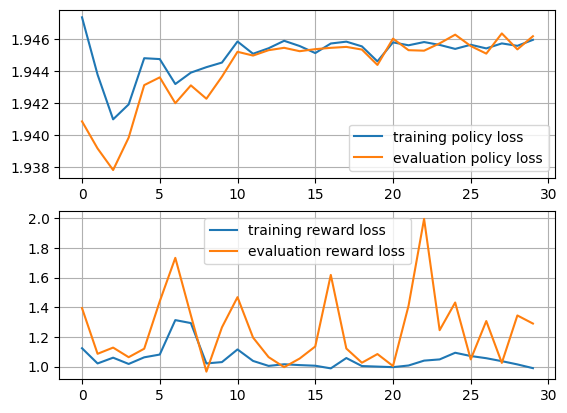


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

available actions: [0 1 2 3 4 5 6]
player B move: 4

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  B  .  .

available actions: [0 1 2 3 4 5 6]
player R move: 1

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  R  .  .  B  .  .

available actions: [0 1 2 3 4 5 6]
player B move: 3

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  R  .  B  B  .  .

available actions: [0 1 2 3 4 5 6]
player R move: 3

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  R  .  B  B  .  .

available actions: [0 1 2 3 4 5 6]
player B move: 4

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  R  B 

In [305]:
alpha0 = AlphaZero(params)

game = alpha0.mcts.game
player = game.first_player
state = game.init_state()

if params["load_model"]:
    model_checkpoint = torch.load(f"./models/model_{game}_latest.pt")
    alpha0.mcts.model.load_state_dict(model_checkpoint["model"])
    alpha0.optimizer.load_state_dict(model_checkpoint["optimizer"])
else:
    losses = alpha0.learn()

    fig, (ax1, ax2) = plt.subplots(2)
    loss_eval_size = params["loss_eval_size"]

    ax1.plot(
        torch.tensor(losses.policy.train).view(-1, loss_eval_size).mean(axis=1)
    )
    ax1.plot(torch.tensor(losses.policy.eval).view(-1, loss_eval_size).mean(axis=1))
    ax1.legend(["training policy loss", "evaluation policy loss"])
    ax1.grid()

    ax2.plot(
        torch.tensor(losses.reward.train).view(-1, loss_eval_size).mean(axis=1)
    )
    ax2.plot(torch.tensor(losses.reward.eval).view(-1, loss_eval_size).mean(axis=1))
    ax2.legend(["training reward loss", "evaluation reward loss"])
    ax2.grid()

    plt.savefig("./images/loss.png")
    plt.show()

untrained_mcts = MCTS(params)

while True:
    print_state(state)

    available_actions = game.available_actions(state)
    print(f"available actions: {game.available_actions(state)}")

    neutral_state = game.neutral_perspective(state, player)

    if player == game.first_player:
        policy = untrained_mcts.best_policy(neutral_state)
    else:
        policy = alpha0.mcts.best_policy(neutral_state)

    action = np.argmax(policy)
    print(f"player {players[player]} move: {action}")

    state = game.next_state(state, action, player)

    is_over = game.is_over(state, action)
    if is_over >= 0:
        print_state(state)
        if is_over == 0:
            print("draw!")
        else:
            print(f"player {players[player]} won!")
        break

    player = game.opponent(player)

## Quick Model Test

In [ ]:
def quick_model_test(model, enc_state):
    model.eval()

    policy, reward = model(enc_state)
    policy = F.softmax(policy, dim=1).squeeze(0).detach().cpu().numpy()

    print(f"\treward: {reward.item()}")
    print("\tpolicy bar plot:")
    plt.bar(range(len(policy)), policy)
    plt.show()
    
game = Connect4()

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
device = params["device"]

state = game.init_state()
state = game.next_state(state, 2, 1)
state = game.next_state(state, 2, -1)
state = game.next_state(state, 4, 1)
state = game.next_state(state, 3, -1)
state = game.next_state(state, 3, 1)
state = game.next_state(state, 4, -1)
state = game.next_state(state, 4, 1)
state = game.next_state(state, 5, -1)
state = game.next_state(state, 2, 1)
state = game.next_state(state, 3, -1)
# state = -state

print("state:")
print_state(state)

enc_state = encode_state(state)
enc_state = torch.tensor(enc_state, dtype=torch.float32).unsqueeze(0)

model = ResNet(game, embd_size, hidden_size, num_blocks, params).to(device)
print("untrained model result:")
quick_model_test(model, enc_state)

model_checkpoint = torch.load(f"./models/model_{game}_latest.pt")
model.load_state_dict(model_checkpoint["model"])

print("trained model result:")
quick_model_test(model, enc_state)


# Batch Processing

The MCTS class processes each state individualy resulting is a slow process of generating a training dataset. We can process states in batches to speed up the process.

First, we start with the encoding states. We generalize it as follows to encode the states in batches.

In [ ]:
def encode_state_parallel(states):
    '''
    b, m, n = states.shape
    output size: b x 3 x m x n
    '''
    out = np.stack(
        [states == 1, states == 0, states == -1]
    ).astype(np.float32)
    out = np.swapaxes(out, 0, 1)
    return out

In [ ]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None, prior_prob=0, visit_count=0):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        
        self.reward_sum = 0
        self.visit_count = visit_count
        self.prior_prob = prior_prob
        
    def ucb(self):
        '''
        Return a vector of UCBs of all children.
        '''
        children_visit_counts = np.array([child.visit_count for child in self.children])
        children_reward_sum = np.array([child.reward_sum for child in self.children])
        children_prior_probs = np.array([child.prior_prob for child in self.children])

        exploration_factor = self.params["exploration_factor"]
        exploration = np.sqrt(self.visit_count) / (1.0 + children_visit_counts)
        expected_reward = -np.divide(children_reward_sum, children_visit_counts,
                                     where=children_visit_counts!=0)
        
        return expected_reward + exploration_factor * children_prior_probs * exploration
     
    def select(self):
        k = np.argmax(self.ucb())
        return self.children[k]
    
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def create_child(self, action, prob):
        player = self.game.first_player
        other_player = self.game.opponent(player)

        child_state = self.game.next_state(self.state.copy(), action, player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        
        child = Node(self.game, child_state, self.params, self, action, prob)
        return child
    
    def expand(self, policy):
        self.children = [self.create_child(a, p) for a, p in enumerate(policy) if p != 0]
            
    def backward(self, reward):
        node = self
        while node is not None:            
            node.reward_sum += reward
            node.visit_count += 1
            reward = self.game.opponent_reward(reward)
            node = node.parent

class MCTS(object):
    def __init__(self, game, model, params):
        self.game = game
        self.model = model
        self.params = params
        
    def select(self, node):
        while node.is_fully_expanded():
            node = node.select()
        return node
    
    @torch.no_grad()
    def best_policies(self, states):
        roots = [Node(self.game, state, self.params, visit_count=1) for state in states]
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            batch_nodes = []
            for root in roots:
                node = self.select(root)

                if self.game.is_over(node.state, node.parent_action):
                    reward = self.game.reward(node.state)
                    reward = self.game.opponent_reward(reward)
                    node.backward(reward)
                else:
                    batch_nodes.append(node)
            
            if len(batch_nodes) == 0:
                continue

            batch_states = np.array([node.state for node in batch_nodes])
            enc_states = encode_state_parallel(batch_states)
            enc_states = torch.tensor(enc_states, device=self.params["device"])

            logits, rewards = self.model(enc_states)
            # mask out illegal moves
            logits[batch_states[:, 0, :] != 0] = -np.inf
            policies = F.softmax(logits, dim=1).detach().cpu().numpy()
            
            for node, policy, reward in zip(batch_nodes, policies, rewards):
                node.expand(policy)
                node.backward(reward.item())
        
        return self.compute_policies(roots)
    
    def compute_policies(self, roots):
        out = np.zeros((len(roots), self.game.ncols))

        for i, root in enumerate(roots):
            for child in root.children:
                out[i, child.parent_action] = child.visit_count

        out /= np.sum(out, axis=1, keepdims=True)
        return out

In [ ]:
class ParallelPlay(object):
    def __init__(self, game):
        self.game = game
        self.current_state = game.init_state()
        self.states = []
        self.policies = []
        self.rewards = []
        self.players = []  

def generate_data(mcts, num_threads):
    '''
    Runs `num_threads` games in parallel and generates data from all the states
    in all the games.
    outout: (states, policies, rewards)
    '''
    game = mcts.game
    player = game.first_player
    par_plays = [ParallelPlay(game) for _ in range(num_threads)]

    # storing all states, policies, and rewards from all the threads.
    out_states, out_policies, out_rewards = [], [], []
    
    while len(par_plays) > 0:
        states = np.array([p.current_state for p in par_plays])
        neutral_states = game.neutral_perspective(states, player)
        policies = mcts.best_policies(neutral_states)
        
        for i in range(len(par_plays)-1, -1, -1):
            par_plays[i].states.append(neutral_states[i])
            par_plays[i].policies.append(policies[i])
            par_plays[i].players.append(player)

            action = np.random.choice(len(policies[i]), p=policies[i])
            par_plays[i].current_state = game.next_state(par_plays[i].current_state, action, player)
            
            if game.is_over(par_plays[i].current_state, action):
                out_states.extend(par_plays[i].states)
                out_policies.extend(par_plays[i].policies)

                reward = game.reward(par_plays[i].current_state)
                out_rewards.extend([reward if p == player else game.opponent_reward(reward) for p in par_plays[i].players])

                del par_plays[i]                
        
        player = game.opponent(player)
        
    return out_states, out_policies, out_rewards
    
def generate_dataset(mcts, num_self_plays, num_threads):
    states, policies, rewards = [], [], []
    
    for _ in trange(num_self_plays // num_threads):
        s, p, r = generate_data(mcts, num_threads)
        states.extend(s)
        policies.extend(p)
        rewards.extend(r)
    
    states, policies, rewards = np.array(states), np.array(policies), np.array(rewards)
    enc_states = encode_state_parallel(states)
    
    return enc_states, policies, rewards

In [ ]:
game = Connect4()

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
device = params["device"]
model = ResNet(game, embd_size, hidden_size, num_blocks, params).to(device)

mcts = MCTS(game, model, params)

In [ ]:
load_data = params["load_data"]
num_threads = params["num_threads"]

if load_data:
    data_checkpoint = torch.load(f"./data/{game}_data.pt")
    train_data = data_checkpoint["train_data"]
    eval_data = data_checkpoint["eval_data"]
else:
    num_self_plays = params["num_self_plays"]
    %prun -T prun.txt train_data = generate_dataset(mcts, num_self_plays, num_threads)
    eval_data = generate_dataset(mcts, int(0.1 * num_self_plays), num_threads)
    data_checkpoint = {
        "train_data": train_data,
        "eval_data": eval_data,
    }
    torch.save(data_checkpoint, f"./data/{game}_data.pt")

In [ ]:
@torch.no_grad()
def eval_model(model, eval_data, params):
    device = params["device"]

    states, policies, rewards = eval_data

    enc_states = torch.tensor(states, dtype=torch.float32, device=device)
    target_policies = torch.tensor(policies, dtype=torch.float32, device=device)
    target_rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)

    pred_logits, pred_rewards = model(enc_states)

    pred_policies = F.softmax(pred_logits, dim=1)
    policy_loss = F.cross_entropy(pred_policies, target_policies)
    reward_loss = F.mse_loss(pred_rewards, target_rewards)
    
    return policy_loss.item(), reward_loss.item()

def train_model(game, model, optimizer, train_data, eval_data, params, losses=None, num_models_to_save=1):
    if losses is None:
        losses = Losses()
    
    states, policies, rewards = train_data
    num_epochs = params["num_epochs"]
    batch_size = params["batch_size"]
    device = params["device"]
    
    for epoch in trange(num_epochs):
        model.train()
        batch_indices = np.random.choice(len(states), batch_size)
        
        enc_states = torch.tensor(states[batch_indices], dtype=torch.float32, device=device)
        target_policies = torch.tensor(policies[batch_indices], dtype=torch.float32, device=device)
        target_rewards = torch.tensor(rewards[batch_indices], dtype=torch.float32, device=device).unsqueeze(1)
        
        pred_logits, pred_rewards = model(enc_states)

        pred_policies = F.softmax(pred_logits, dim=1)
        policy_loss = F.cross_entropy(pred_policies, target_policies)
        reward_loss = F.mse_loss(pred_rewards, target_rewards)
        
        losses.policy.train.append(policy_loss.item())
        losses.reward.train.append(reward_loss.item())
        
        optimizer.zero_grad(set_to_none=True)
        policy_loss.backward(retain_graph=True)
        reward_loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (num_epochs/num_models_to_save) == 0:
            model_checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            torch.save(model_checkpoint, f"./models/{game}_{epoch+1}.pt")
        
        model.eval()
        policy_loss, reward_loss = eval_model(model, eval_data, params)
        losses.policy.eval.append(policy_loss)
        losses.reward.eval.append(reward_loss)
        
    return losses


In [ ]:
class Loss(object):
    def __init__(self):
        self.train = []
        self.eval = []

class Losses(object):
    def __init__(self):
        self.policy = Loss()
        self.reward = Loss()

losses = None

In [ ]:
load_model = params["load_model"]
num_epochs = params["num_epochs"]
lr = params["lr"]
weight_decay = params["weight_decay"]

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if load_model:
    model_checkpoint = torch.load(f"./models/{game}_{num_epochs}.pt")
    model = model_checkpoint["model"]
    optimizer = model_checkpoint["optimizer"]
else:
    num_models_to_save = 1
    losses = train_model(game, model, optimizer, train_data, eval_data, params, losses, 
                num_models_to_save=num_models_to_save)

In [ ]:
plt.plot(losses.policy.train)
plt.plot(losses.policy.eval)
plt.legend(["training loss", "evaluation loss"])
plt.show()

In [ ]:
plt.plot(losses.reward.train)
plt.plot(losses.reward.eval)
plt.legend(["training loss", "evaluation loss"])
plt.show()

In [ ]:
game = Connect4()
state = game.init_state()
player = game.first_player

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
device = params["device"]
model = ResNet(game, embd_size, hidden_size, num_blocks, params).to(device)

num_epochs = params["num_epochs"]
model_checkpoint = torch.load(f"./models/{game}_100.pt")
model.load_state_dict(model_checkpoint["model"])
model.eval()

mcts = MCTS(game, model, params)

while True:
    print_state(state)
    available_actions = game.available_actions(state)
    
    if len(available_actions) == 0:
        print("draw!")
        break

    print(f"player {players[player]} to move...")
    print(f"available moves: ")

    if player == game.first_player:
        action = int(input("provide your move: "))
    else:
        neutral_state = game.neutral_perspective(state, player)

        policy = mcts.best_policies([neutral_state])
        policy = policy[0]

        # enc_neutral_state = torch.tensor(encode_state(neutral_state), dtype=torch.float32).unsqueeze(0)        
        # logit, reward = model(enc_neutral_state)
        # print(f"predicted reward: {reward.item()}")
        # policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()

        action = np.argmax(policy)
        
        plt.bar(range(len(policy)), policy)
        plt.show()
    
    state = game.next_state(state, action, player)
    
    if game.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = game.opponent(player)

# Draft

In [ ]:
losses = torch.load(f"./data/{game}_losses.pt")

eval_size = 100
plt.plot(torch.tensor(losses.policy.train).view(-1, eval_size).mean(axis=1))
plt.plot(torch.tensor(losses.policy.eval).view(-1, eval_size).mean(axis=1))
plt.legend(["training loss", "evaluation loss"])
plt.grid()
plt.show()

In [ ]:
plt.plot(torch.tensor(losses.reward.train).view(-1, eval_size).mean(axis=1))
plt.plot(torch.tensor(losses.reward.eval).view(-1, eval_size).mean(axis=1))
plt.legend(["training loss", "evaluation loss"])
plt.grid()
plt.show()

In [ ]:
s, p, r = torch.load(f"./data/data_{game}_4.pt")
s, p, r = np.array(s), np.array(p), np.array(r)
print(s.shape, p.shape, r.shape)

In [ ]:
# k = 0
skip = False

for k in range(len(s)):
    state = decode_state(s[k])
    
    if np.sum(state != 0) == 0 and skip:
        break

    print_state(state)
    skip = True
    
    plt.bar(range(len(p[k])), p[k])
    plt.show()
    
    print(r[k])